In [436]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import time

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor

# Save off the model/scaler
import pickle

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [438]:
# Load the cleaned data
df_cleaned = pd.read_csv('../Resources/cleaned_data.csv')


# Preprocessing Pipeline

## Feature Engineering

In [442]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   brand                    4009 non-null   object 
 1   model_year               4009 non-null   int64  
 2   mileage                  4009 non-null   float64
 3   fuel_type                4009 non-null   object 
 4   accident                 4009 non-null   object 
 5   clean_title              4009 non-null   object 
 6   price                    4009 non-null   float64
 7   transmission_category    4009 non-null   object 
 8   exterior_color_category  4009 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 282.0+ KB


In [444]:
df_cleaned['car_age'] = 2025 - df_cleaned['model_year']

In [446]:
# Convert 'Yes' and 'No' to lowercase before mapping
df_cleaned['clean_title'] = df_cleaned['clean_title'].str.lower()

# Map 'yes' to 1 and 'no' to 0
df_cleaned['clean_title'] = df_cleaned['clean_title'].map({'yes': 1, 'no': 0})

# Check the result
df_cleaned['clean_title'].head()

0    1
1    1
2    0
3    1
4    0
Name: clean_title, dtype: int64

In [448]:
features = ['brand','model_year','car_age', 'mileage', 
            'fuel_type', 'transmission_category', 
            'exterior_color_category', 'accident', 'clean_title', 'price']

df2 = df_cleaned.loc[:, features]
df2.head()


,brand,model_year,car_age,mileage,fuel_type,transmission_category,exterior_color_category,accident,clean_title,price
0,Ford,2013,12,51000.0,E85 Flex Fuel,Automatic,Black,Yes,1,10300.0
1,Hyundai,2021,4,34742.0,Gasoline,Automatic,Other,Yes,1,38005.0
2,Lexus,2022,3,22372.0,Gasoline,Automatic,Blue,No,0,54598.0
3,INFINITI,2015,10,88900.0,Hybrid,Automatic,Black,No,1,15500.0
4,Audi,2021,4,9835.0,Gasoline,Automatic,Other,No,0,34999.0


In [450]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   brand                    4009 non-null   object 
 1   model_year               4009 non-null   int64  
 2   car_age                  4009 non-null   int64  
 3   mileage                  4009 non-null   float64
 4   fuel_type                4009 non-null   object 
 5   transmission_category    4009 non-null   object 
 6   exterior_color_category  4009 non-null   object 
 7   accident                 4009 non-null   object 
 8   clean_title              4009 non-null   int64  
 9   price                    4009 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 313.3+ KB


In [452]:
# Define preprocessing for numeric features (model_year, mileage, car_age)
numeric_features = ['model_year', 'mileage', 'car_age']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values with median
    ('scaler', StandardScaler())])  # Scale numerical features

# Define preprocessing for categorical features (brand, fuel_type, transmission_category, exterior_color_category, accident)
categorical_features = ['brand', 'fuel_type', 'transmission_category', 'exterior_color_category', 'accident']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),  # Fill missing values with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])  # One-hot encoding for categorical features (return dense)

# Combine preprocessing for numeric and categorical features using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply the transformation to the data
preprocessed_X_train = preprocessor.fit_transform(df_cleaned)

# Step 2: Get the number of features in the transformed data
print(f"Shape of transformed data: {preprocessed_X_train.shape}")

Shape of transformed data: (4009, 51)


In [454]:
# Correlation Analysis (this is optional and not needed for the ML Experiment)
# It just shows what the data looks like after transformation before training
# We will still declare a full pipeline of preprocessing + training

# Use only preprocessing pipeline to transform the data
preprocessed_X_train = preprocessor.fit_transform(df_cleaned)

# Convert preprocessed data to a DataFrame
# Get the feature names after one-hot encoding
encoded_feature_names = (numeric_features +list(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)))

df_final = pd.DataFrame(preprocessed_X_train, columns=encoded_feature_names)
df_final["price"] = df_cleaned.price
df_final.head()

,model_year,mileage,car_age,brand_Acura,brand_Audi,brand_BMW,brand_Cadillac,brand_Chevrolet,brand_Dodge,brand_Ford,brand_GMC,brand_Honda,brand_Hyundai,brand_INFINITI,brand_Jeep,brand_Kia,brand_Land,brand_Lexus,brand_Lincoln,brand_Mazda,brand_Mercedes-Benz,brand_Nissan,brand_Other,brand_Porsche,brand_RAM,brand_Subaru,brand_Tesla,brand_Toyota,brand_Volkswagen,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Electric,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,fuel_type_Unknown,transmission_category_Automatic,transmission_category_Dual-Shift,transmission_category_Manual,transmission_category_Other,exterior_color_category_Black,exterior_color_category_Blue,exterior_color_category_Gray,exterior_color_category_Green,exterior_color_category_Other,exterior_color_category_Red,exterior_color_category_Silver,exterior_color_category_White,accident_No,accident_Unknown,accident_Yes,price
0,-0.412118,-0.262336,0.412118,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10300.0
1,0.898486,-0.573255,-0.898486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,38005.0
2,1.062312,-0.809820,-1.062312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,54598.0
3,-0.084467,0.462467,0.084467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15500.0
4,0.898486,-1.049579,-0.898486,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,34999.0


In [456]:
# Assuming 'df_cleaned' is the original DataFrame and 'df_final' is the transformed DataFrame
# Extract the 'clean_title' binary feature from the original DataFrame
clean_title = df_cleaned['clean_title']

# Add the 'clean_title' column to df_final (after pipeline transformation)
df_final['clean_title'] = clean_title

# Now df_final includes the transformed features along with the 'clean_title'


In [458]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   model_year                        4009 non-null   float64
 1   mileage                           4009 non-null   float64
 2   car_age                           4009 non-null   float64
 3   brand_Acura                       4009 non-null   float64
 4   brand_Audi                        4009 non-null   float64
 5   brand_BMW                         4009 non-null   float64
 6   brand_Cadillac                    4009 non-null   float64
 7   brand_Chevrolet                   4009 non-null   float64
 8   brand_Dodge                       4009 non-null   float64
 9   brand_Ford                        4009 non-null   float64
 10  brand_GMC                         4009 non-null   float64
 11  brand_Honda                       4009 non-null   float64
 12  brand_

In [460]:
# Feature selection
# correlation analysis
corrs = df_final.corr()
corrs

,model_year,mileage,car_age,brand_Acura,brand_Audi,brand_BMW,brand_Cadillac,brand_Chevrolet,brand_Dodge,brand_Ford,brand_GMC,brand_Honda,brand_Hyundai,brand_INFINITI,brand_Jeep,brand_Kia,brand_Land,brand_Lexus,brand_Lincoln,brand_Mazda,brand_Mercedes-Benz,brand_Nissan,brand_Other,brand_Porsche,brand_RAM,brand_Subaru,brand_Tesla,brand_Toyota,brand_Volkswagen,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Electric,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,fuel_type_Unknown,transmission_category_Automatic,transmission_category_Dual-Shift,transmission_category_Manual,transmission_category_Other,exterior_color_category_Black,exterior_color_category_Blue,exterior_color_category_Gray,exterior_color_category_Green,exterior_color_category_Other,exterior_color_category_Red,exterior_color_category_Silver,exterior_color_category_White,accident_No,accident_Unknown,accident_Yes,price,clean_title
model_year,1.000000,-0.617720,-1.000000,-0.016953,0.042022,0.015108,-0.002324,-0.045218,-0.067419,0.020500,0.029105,-0.037616,0.010424,-0.020165,-0.003906,0.089240,0.062975,-0.018010,-0.004988,-0.016627,0.010721,-0.046273,-0.060456,-0.030829,0.088642,-0.003260,0.105773,-0.042446,0.011056,0.002728,-0.052193,0.169632,-0.099148,0.148721,0.061706,-0.235866,0.107660,0.008991,-0.245663,0.005964,0.010877,-0.023173,0.037638,-0.056515,0.121470,-0.078440,-0.106830,0.014150,0.188222,-0.001052,-0.194561,0.199496,-0.264272
mileage,-0.617720,1.000000,0.617720,0.024617,-0.030694,-0.046177,0.020414,0.035244,0.068348,0.047303,0.038088,0.064128,0.003689,0.040454,0.006012,-0.040401,-0.026540,0.052782,0.016202,-0.000092,-0.050657,0.056579,-0.075626,-0.092917,-0.030395,0.027165,-0.082438,0.090199,0.001619,0.092910,0.145688,-0.157549,0.023107,-0.095878,-0.056122,0.061583,-0.000324,-0.036469,0.079273,-0.027926,0.055449,-0.015127,-0.028196,0.005443,-0.126680,0.015322,0.077062,0.017191,-0.272352,-0.049603,0.301174,-0.305528,0.253614
car_age,-1.000000,0.617720,1.000000,0.016953,-0.042022,-0.015108,0.002324,0.045218,0.067419,-0.020500,-0.029105,0.037616,-0.010424,0.020165,0.003906,-0.089240,-0.062975,0.018010,0.004988,0.016627,-0.010721,0.046273,0.060456,0.030829,-0.088642,0.003260,-0.105773,0.042446,-0.011056,-0.002728,0.052193,-0.169632,0.099148,-0.148721,-0.061706,0.235866,-0.107660,-0.008991,0.245663,-0.005964,-0.010877,0.023173,-0.037638,0.056515,-0.121470,0.078440,0.106830,-0.014150,-0.188222,0.001052,0.194561,-0.199496,0.264272
brand_Acura,-0.016953,0.024617,0.016953,1.000000,-0.029186,-0.040916,-0.021092,-0.035699,-0.019302,-0.041574,-0.019411,-0.016094,-0.017225,-0.015567,-0.024496,-0.017706,-0.023317,-0.026221,-0.014601,-0.016223,-0.037194,-0.021986,-0.045291,-0.029263,-0.019411,-0.016223,-0.018970,-0.029109,-0.015567,-0.021986,-0.024139,-0.026885,0.037613,-0.010174,-0.011780,0.023651,-0.022474,-0.002354,-0.008266,0.167763,0.007193,-0.018420,0.012583,-0.002681,-0.030098,0.020230,-0.001623,0.010519,-0.002032,-0.009667,0.005820,-0.026735,-0.053062
brand_Audi,0.042022,-0.030694,-0.042022,-0.029186,1.000000,-0.073609,-0.037945,-0.064225,-0.034725,-0.074794,-0.034922,-0.028954,-0.030988,-0.028005,-0.044070,-0.031853,-0.041949,-0.047174,-0.026268,-0.029186,-0.066914,-0.039555,-0.081480,-0.052645,-0.034922,-0.029186,-0.034128,-0.052369,-0.028005,-0.012214,0.006673,-0.014349,-0.060597,0.145873,-0.021192,-0.024687,-0.038719,0.061857,-0.030188,-0.013070,0.015283,-0.006317,0.035686,-0.031423,0.009138,-0.048875,-0.001955,-0.006133,-0.008151,0.002511,0.007478,-0.013527,-0.042726
brand_BMW,0.015108,-0.046177,-0.015108,-0.040916,-0.073609,1.000000,-0.053195,-0.090036,-0.048681,-0.104853,-0.048957,-0.040590,-0.043442,-0.039260,-0.061782,-0.044655,-0.058808,-0.066132,-0.036825,-0.040916,-0.093806,-0.055451,-0.114226,-0.073803,-0.048957,-0.040916,-0.047844,-0.073415,-0.039260,-0.055451,-0.060880,-0.046610,0.059746,0.003406,0.110414,-0.034609,-0.114764,0.131119,-0.003924,-0.003255,0.036937,0.021412,0.030191,0.000497,-0.062412,-0.046985,-0.016094,0.016642,0.02074

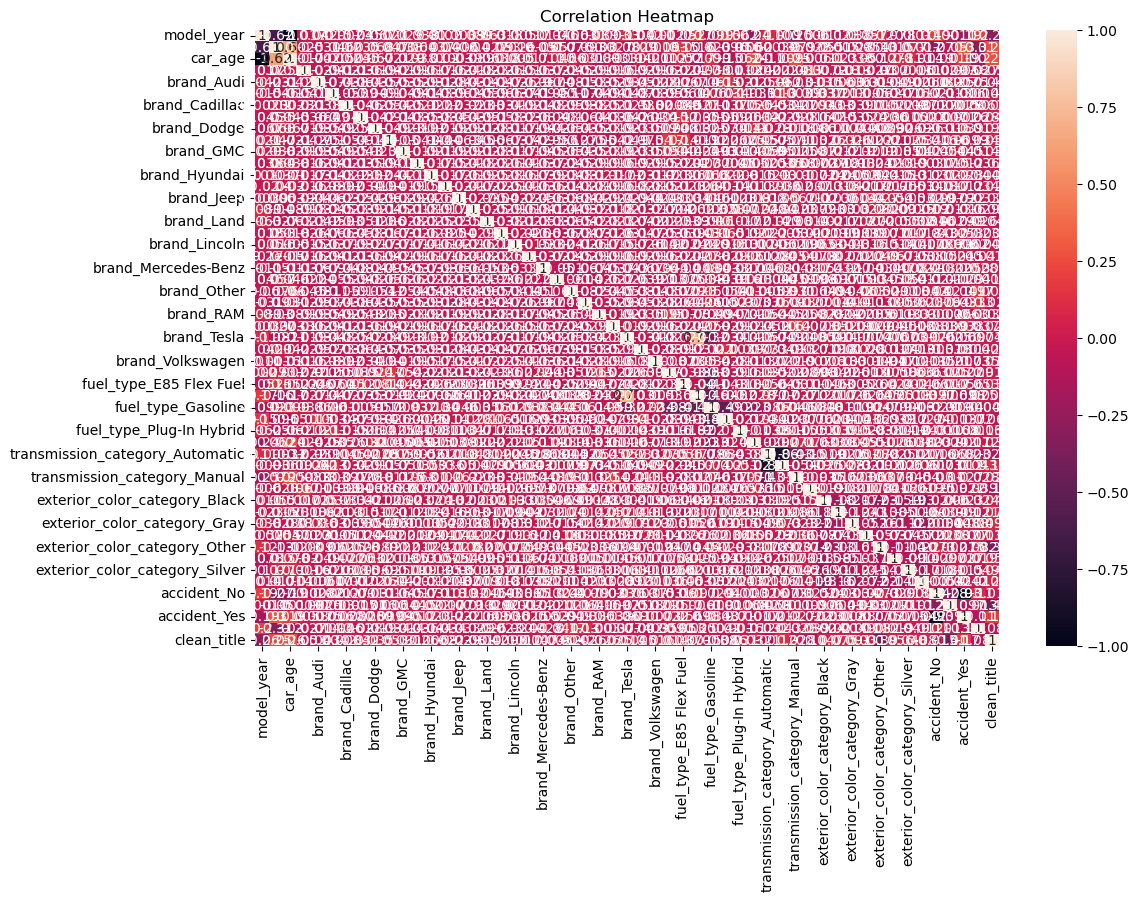

In [462]:
plt.figure(figsize=(12,8))
sns.heatmap(corrs, annot=True)
plt.title("Correlation Heatmap")
plt.show()

In [463]:
abs(corrs.price).sort_values(ascending=False)

price                               1.000000
mileage                             0.305528
model_year                          0.199496
car_age                             0.199496
brand_Other                         0.172349
brand_Porsche                       0.129025
accident_Yes                        0.114088
accident_No                         0.105135
clean_title                         0.085710
exterior_color_category_Other       0.082275
fuel_type_E85 Flex Fuel             0.052518
exterior_color_category_Silver      0.049475
brand_Hyundai                       0.044000
transmission_category_Dual-Shift    0.042848
brand_Toyota                        0.042186
brand_Nissan                        0.040902
brand_Mazda                         0.039719
transmission_category_Other         0.039140
brand_Subaru                        0.037317
brand_Honda                         0.036275
brand_Volkswagen                    0.034918
brand_Ford                          0.034475
brand_INFI

In [464]:
df_final["log_price"] = np.log1p(df_final["price"])

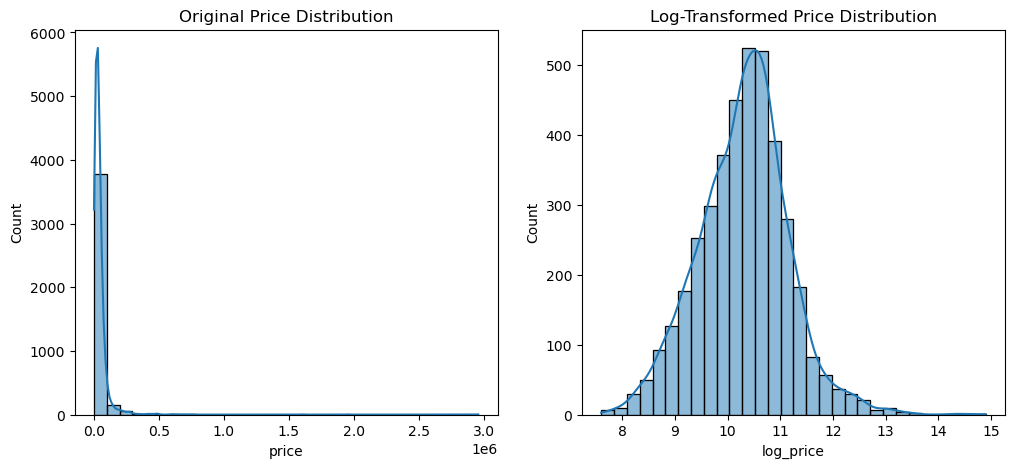

In [465]:
plt.figure(figsize=(12, 5))

# Original Price Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_final["price"], bins=30, kde=True)
plt.title("Original Price Distribution")

# Log-Transformed Price Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_final["log_price"], bins=30, kde=True)
plt.title("Log-Transformed Price Distribution")

plt.show()


In [466]:
# Step 1: Get the Data
X = df_final.drop(columns=["price","log_price"])
y = df_final.log_price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) # stratify ensures same % of the target classes in the train/test

print(X.shape)
print(X_train.shape)
print(X_test.shape)

# Combine the features and target variable for training and test data
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Save the DataFrames to CSV files
train_data.to_csv('../Resources/train_data.csv', index=False)
test_data.to_csv('../Resources/test_data.csv', index=False)

(4009, 52)
(3006, 52)
(1003, 52)


In [467]:
# Function for Regression
def doRegression(model, X_train, X_test, y_train, y_test):
    # Step 3: Fit the model
    model.fit(X_train, y_train)
    
    # Step 4: Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Generate metrics TRAIN
    train_r2 = r2_score(y_train, train_preds)
    train_mse = mean_squared_error(y_train, train_preds)
    train_mae = mean_absolute_error(y_train, train_preds)
    train_rmse = np.sqrt(train_mse)
    
    train_results = f"""TRAIN METRICS
    R2: {train_r2}
    MSE: {train_mse}
    RMSE: {train_rmse}
    MAE: {train_mae}
    """
    
    print(train_results)

    # Generate metrics TEST
    test_r2 = r2_score(y_test, test_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(test_mse)
    
    test_results = f"""TEST METRICS
    R2: {test_r2}
    MSE: {test_mse}
    RMSE: {test_rmse}
    MAE: {test_mae}
    """
    
    print(test_results)

    # VISUALIZE TEST RESULTS
    # Predicted vs Actual Plot
    plt.scatter(y_test, test_preds)
    plt.plot(y_test, y_test)
    plt.title("Predicted vs Actual Plot")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

    # Residual Plot
    resids = test_preds - y_test
    plt.scatter(test_preds, resids)
    plt.hlines(0, min(test_preds), max(test_preds))
    plt.title("Residual Plot")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.show()

In [468]:
# Function for Regression
def doRegression(model, X_train, X_test, y_train, y_test):
    # Step 3: Fit the model
    model.fit(X_train, y_train)
    
    # Step 4: Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Generate metrics TRAIN
    train_r2 = r2_score(y_train, train_preds)
    train_mse = mean_squared_error(y_train, train_preds)
    train_mae = mean_absolute_error(y_train, train_preds)
    train_rmse = np.sqrt(train_mse)
    
    train_results = f"""TRAIN METRICS
    R2: {train_r2}
    MSE: {train_mse}
    RMSE: {train_rmse}
    MAE: {train_mae}
    """
    
    print(train_results)

    # Generate metrics TEST
    test_r2 = r2_score(y_test, test_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(test_mse)
    
    test_results = f"""TEST METRICS
    R2: {test_r2}
    MSE: {test_mse}
    RMSE: {test_rmse}
    MAE: {test_mae}
    """
    
    print(test_results)

    # VISUALIZE TEST RESULTS
    # Predicted vs Actual Plot
    plt.scatter(y_test, test_preds)
    plt.plot(y_test, y_test)
    plt.title("Predicted vs Actual Plot")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

    # Residual Plot
    resids = test_preds - y_test
    plt.scatter(test_preds, resids)
    plt.hlines(0, min(test_preds), max(test_preds))
    plt.title("Residual Plot")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.show()

TRAIN METRICS
    R2: 0.6646945865917917
    MSE: 0.2388931450072299
    RMSE: 0.4887669639073716
    MAE: 0.3623355559776517
    
TEST METRICS
    R2: 0.6103369848442275
    MSE: 0.2931176451345132
    RMSE: 0.5414034033274202
    MAE: 0.3842824090293779
    


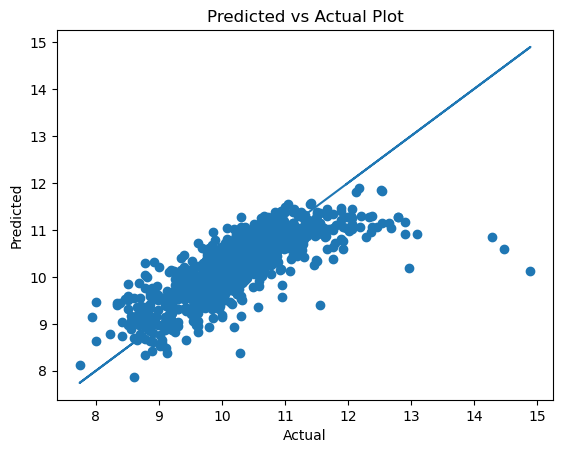

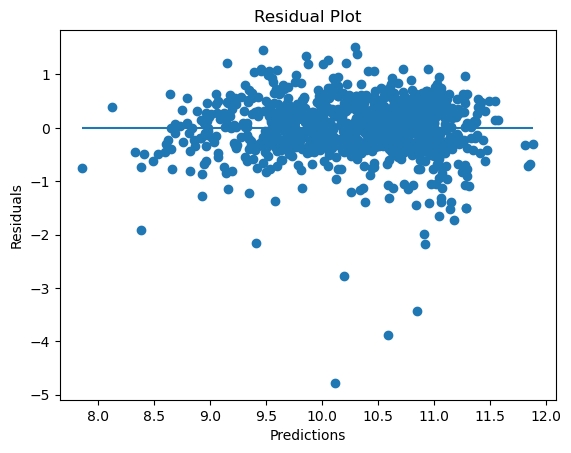

In [469]:
# Step 2: Init the model
lr = LinearRegression()

doRegression(lr, X_train, X_test, y_train, y_test)

TRAIN METRICS
    R2: 0.6646734858865024
    MSE: 0.23890817850697924
    RMSE: 0.48878234267102905
    MAE: 0.3622592852030637
    
TEST METRICS
    R2: 0.6104213029671051
    MSE: 0.2930542182023725
    RMSE: 0.5413448237513429
    MAE: 0.38420997903535514
    


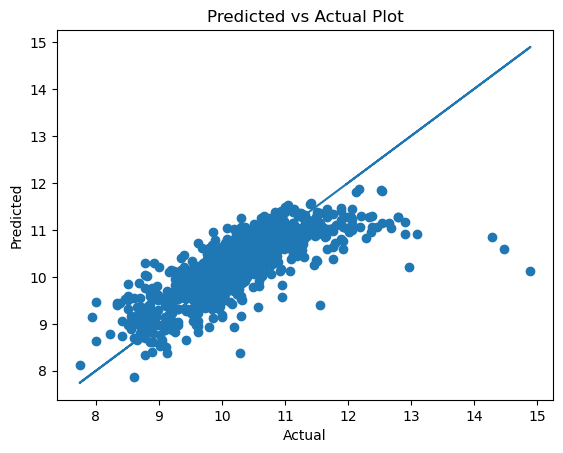

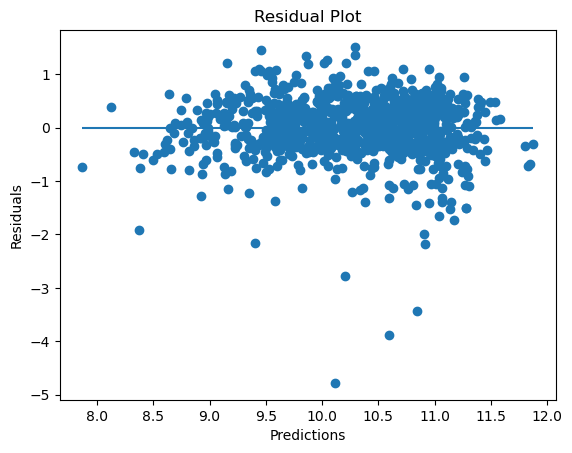

In [470]:
# Step 2: Init the Model
ridge = Ridge()

# Do Machine Learning
doRegression(ridge, X_train, X_test, y_train, y_test)

TRAIN METRICS
    R2: 0.0
    MSE: 0.7124643249239643
    RMSE: 0.8440760184509238
    MAE: 0.6574900345895703
    
TEST METRICS
    R2: -2.7899974324840926e-05
    MSE: 0.7522546705955812
    RMSE: 0.86732616159988
    MAE: 0.6607111905246855
    


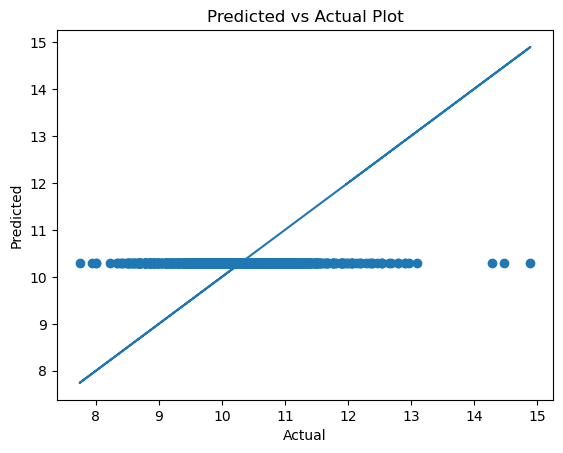

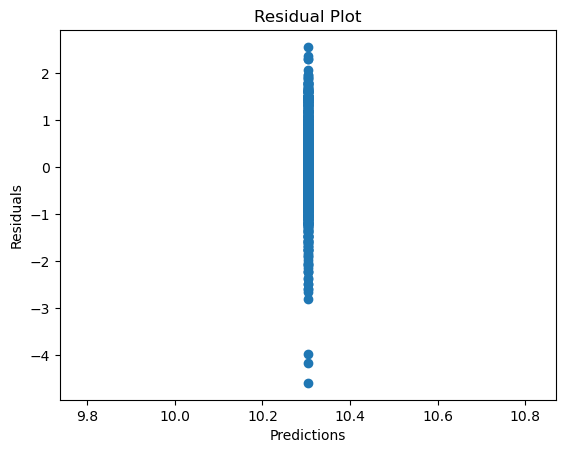

In [482]:
 # Step 2: Init the Model
lasso = Lasso()

# Do Machine Learning
doRegression(lasso, X_train, X_test, y_train, y_test)

TRAIN METRICS
    R2: 0.9583318077611536
    MSE: 0.029687100454251707
    RMSE: 0.1722994499534218
    MAE: 0.12890375567392967
    
TEST METRICS
    R2: 0.6679266774902687
    MSE: 0.2497967385155471
    RMSE: 0.4997966971835119
    MAE: 0.3599356054051174
    


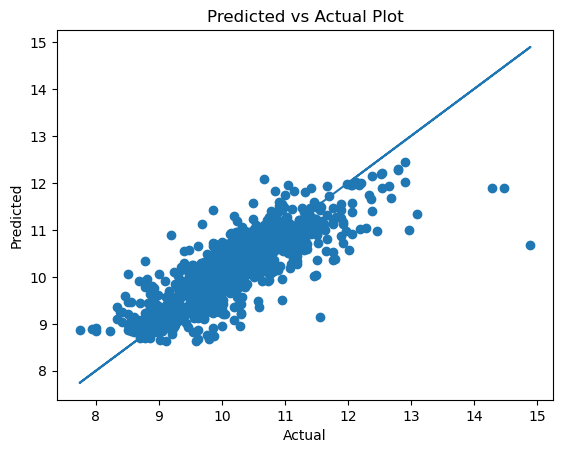

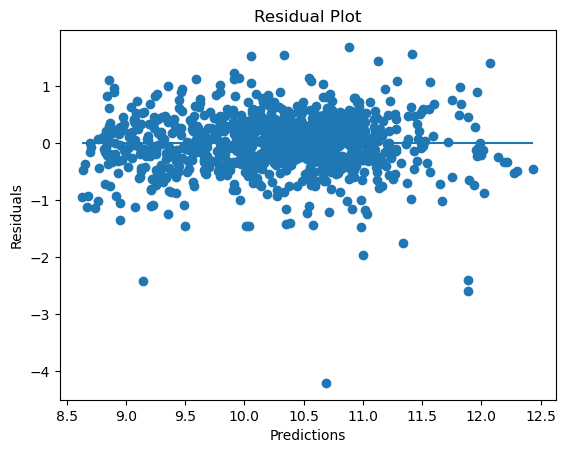

In [484]:
# Step 2: Init the Model
rf = RandomForestRegressor(random_state=42)

# Do Machine Learning
doRegression(rf, X_train, X_test, y_train, y_test)

TRAIN METRICS
    R2: 0.7577784701310586
    MSE: 0.1725741987601252
    RMSE: 0.4154205083528318
    MAE: 0.3187170769571661
    
TEST METRICS
    R2: 0.6669126542992614
    MSE: 0.25055952091546524
    RMSE: 0.5005592082016525
    MAE: 0.3588918611962394
    


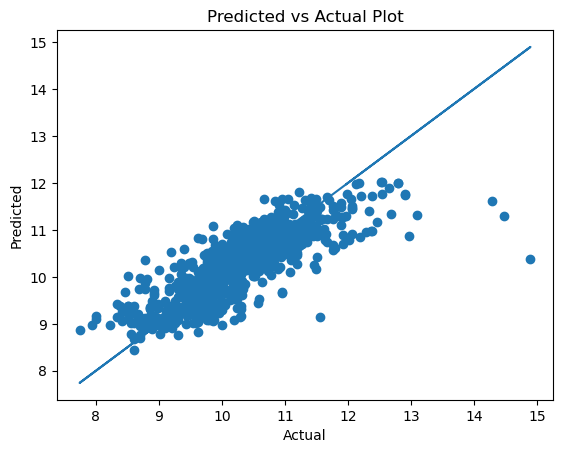

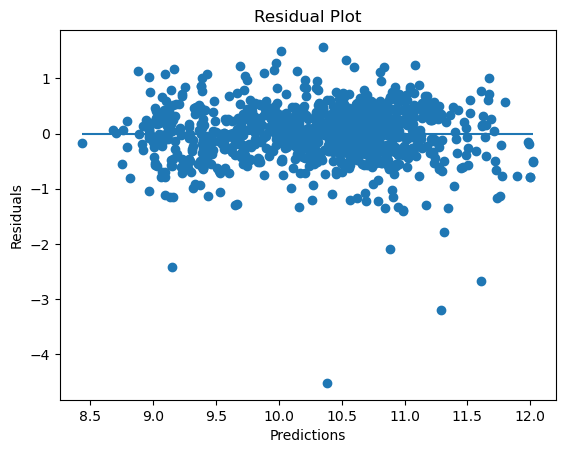

In [485]:
# Step 2: Init the Model
gb = GradientBoostingRegressor(random_state=42)

# Do Machine Learning
doRegression(gb, X_train, X_test, y_train, y_test)


TRAIN METRICS
    R2: 0.9303272592482471
    MSE: 0.04963934220530003
    RMSE: 0.22279888286367153
    MAE: 0.16308794690451311
    
TEST METRICS
    R2: 0.6816742001296655
    MSE: 0.2394553889243304
    RMSE: 0.4893417915162473
    MAE: 0.355805449733249
    


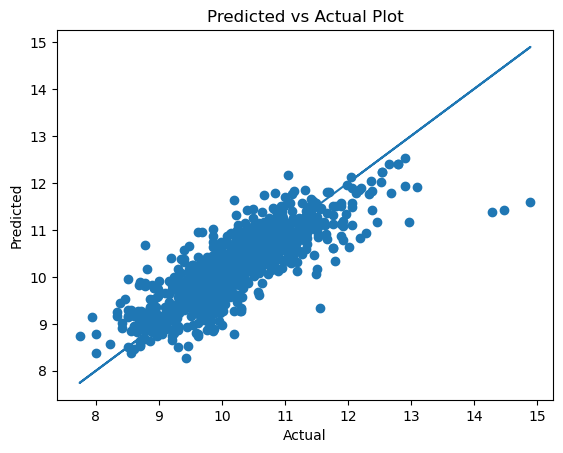

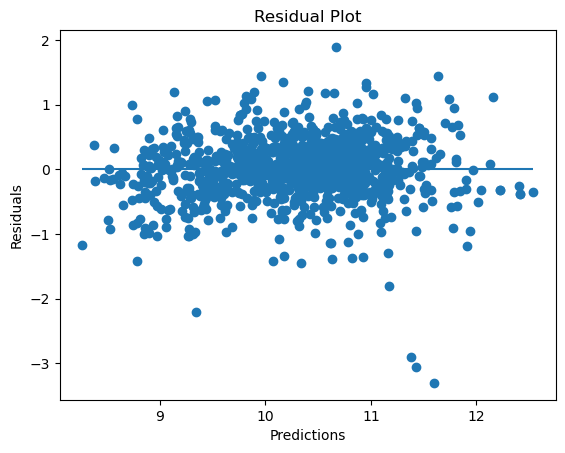

In [486]:
# Step 2: Init the Model
xgb = XGBRegressor(random_state=42)

# Do Machine Learning
doRegression(xgb, X_train, X_test, y_train, y_test)


Learning rate set to 0.048719
0:	learn: 0.8222877	total: 13.4ms	remaining: 13.4s
1:	learn: 0.8009339	total: 15.3ms	remaining: 7.64s
2:	learn: 0.7805202	total: 17ms	remaining: 5.63s
3:	learn: 0.7607738	total: 18.5ms	remaining: 4.6s
4:	learn: 0.7415085	total: 20ms	remaining: 3.98s
5:	learn: 0.7251663	total: 21.7ms	remaining: 3.6s
6:	learn: 0.7092778	total: 23.4ms	remaining: 3.32s
7:	learn: 0.6942183	total: 25ms	remaining: 3.1s
8:	learn: 0.6796720	total: 26.7ms	remaining: 2.94s
9:	learn: 0.6660717	total: 28.1ms	remaining: 2.78s
10:	learn: 0.6533244	total: 29.8ms	remaining: 2.68s
11:	learn: 0.6409265	total: 31.5ms	remaining: 2.6s
12:	learn: 0.6315248	total: 33.3ms	remaining: 2.53s
13:	learn: 0.6206503	total: 34.8ms	remaining: 2.45s
14:	learn: 0.6106231	total: 36.6ms	remaining: 2.4s
15:	learn: 0.6019987	total: 38.2ms	remaining: 2.35s
16:	learn: 0.5941617	total: 39.9ms	remaining: 2.31s
17:	learn: 0.5859934	total: 41.6ms	remaining: 2.27s
18:	learn: 0.5792758	total: 43.3ms	remaining: 2.23s
19:

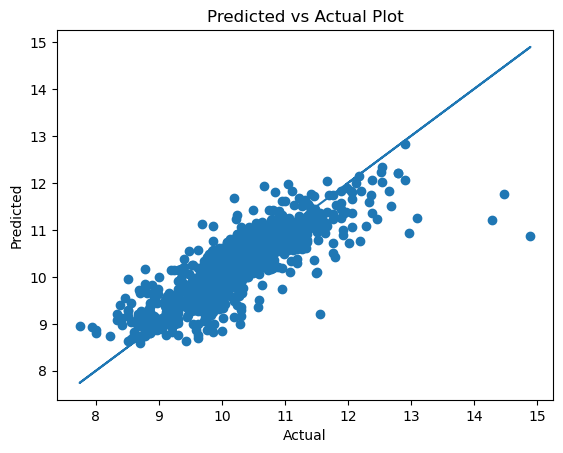

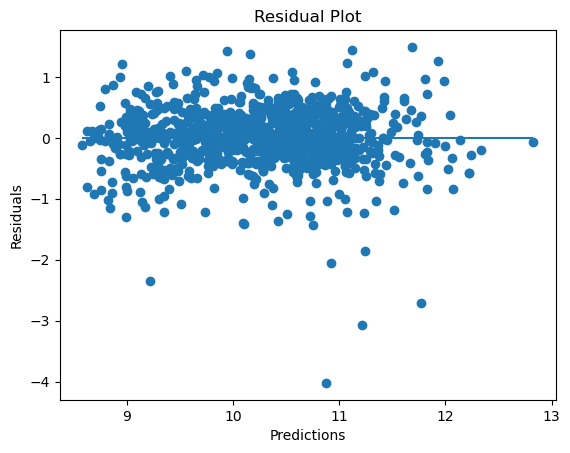

In [489]:
# Step 2: Initialize the CatBoost model
catboost_model = CatBoostRegressor(random_state=42)

# Step 3: Call the doRegression function 
doRegression(catboost_model, X_train, X_test, y_train, y_test)

In [516]:
fi = pd.DataFrame(list(zip(X.columns, catboost_model.feature_importances_)), columns=["Feature", "Importance"])
fi = fi.sort_values(by="Importance", ascending=False)
fi

,Feature,Importance
1,mileage,39.408600
0,model_year,13.113609
2,car_age,9.311852
22,brand_Other,6.256081
23,brand_Porsche,5.390170
29,fuel_type_Diesel,1.972534
12,brand_Hyundai,1.328375
20,brand_Mercedes-Benz,1.308262
44,exterior_color_category_Other,1.269046
50,accident_Yes,1.029403


In [518]:
# Save model
model = pickle.dump(xgb, open("model_pipeline.pkl", 'wb'))
# wb = write binary for the h5 file


In [520]:
print(X.columns)

Index(['model_year', 'mileage', 'car_age', 'brand_Acura', 'brand_Audi',
       'brand_BMW', 'brand_Cadillac', 'brand_Chevrolet', 'brand_Dodge',
       'brand_Ford', 'brand_GMC', 'brand_Honda', 'brand_Hyundai',
       'brand_INFINITI', 'brand_Jeep', 'brand_Kia', 'brand_Land',
       'brand_Lexus', 'brand_Lincoln', 'brand_Mazda', 'brand_Mercedes-Benz',
       'brand_Nissan', 'brand_Other', 'brand_Porsche', 'brand_RAM',
       'brand_Subaru', 'brand_Tesla', 'brand_Toyota', 'brand_Volkswagen',
       'fuel_type_Diesel', 'fuel_type_E85 Flex Fuel', 'fuel_type_Electric',
       'fuel_type_Gasoline', 'fuel_type_Hybrid', 'fuel_type_Plug-In Hybrid',
       'fuel_type_Unknown', 'transmission_category_Automatic',
       'transmission_category_Dual-Shift', 'transmission_category_Manual',
       'transmission_category_Other', 'exterior_color_category_Black',
       'exterior_color_category_Blue', 'exterior_color_category_Gray',
       'exterior_color_category_Green', 'exterior_color_category_Other',